In [19]:
# IMPORT MODULES
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# New modules
import data_loading as dl
import backtesting_engine as be
import performances as perf

# ADJUSTMENTS

import sqlite3



In [3]:
# DATA LOADING
# noisy = 0               # Set to 1 for detailed report on loading
# dataframe = dl.get('@S_60min.txt',noisy)


con = sqlite3.connect('db\hist_data.db')
cur = con.cursor()

query = """
SELECT * FROM stocks
WHERE Ticker='TSLA'
ORDER BY Timestamp
"""


dataframe = pd.read_sql_query(query, con)
con.close()


,Open,High,Low,Close,Volume,AvgPrice,Range,MidPrice,MidBodyPrice
Date_Time,,,,,,,,,
2007-01-01 20:00:00,80.75,81.75,79.50,81.75,214,80.9375,2.25,80.625,81.250
2007-01-01 21:00:00,81.75,82.00,80.50,81.25,54,81.3750,1.50,81.250,81.500
2007-01-01 22:00:00,81.00,81.25,78.75,79.25,93,80.0625,2.50,80.000,80.125
2007-01-01 23:00:00,78.75,80.75,78.75,80.50,125,79.6875,2.00,79.750,79.625
2007-01-02 00:00:00,80.25,80.25,80.25,80.25,28,80.2500,0.00,80.250,80.250
...,...,...,...,...,...,...,...,...,...
2020-11-30 10:00:00,1174.25,1179.50,1171.50,1176.75,15700,1175.5000,8.00,1175.500,1175.500
2020-11-30 11:00:00,1176.75,1177.50,1174.00,1176.25,7315,1176.1250,3.50,1175.750,1176.500
2020-11-30 12:00:00,1176.00,1176.50,1171.00,1172.75,8455,1174.0625,5.50,1173.750,1174.375


In [13]:
dataframev2 = dataframe.set_index(keys='Timestamp').rename(columns={'Close':'Open'}).drop(['Ticker'],axis=1)

dataframev2['Close'] = dataframev2['Open']
dataframev2['Low'] = dataframev2['Open']


dataframev2

,Open,Close,Low
Timestamp,,,
2022-02-28 14:30:00,822.260,822.260,822.260
2022-02-28 14:31:00,818.580,818.580,818.580
2022-02-28 14:32:00,823.400,823.400,823.400
2022-02-28 14:33:00,826.730,826.730,826.730
2022-02-28 14:34:00,829.280,829.280,829.280
...,...,...,...
2022-03-08 16:27:00,813.880,813.880,813.880
2022-03-08 16:28:00,813.128,813.128,813.128
2022-03-08 16:29:00,813.760,813.760,813.760


In [ ]:
##################### DUMB

In [23]:
def backtest(dataframe, rules, strat, strat_start, end= 2000, fees = 0.05):
    '''
    backtesting function.
    input are the data as pandas df, the rules as dictionary
    starting and end point and value for fees
    output is the pandas df with the performance of every trade
    '''

    # ****************** INITIALIZATION PHASE ****************** #

    start = strat_start()                   # Grabs starting time from strategy script
    # length = len(dataframe) - start       # Not used. Ommit last period, so that profit calculation can be made
    
    # Dummy for stop loss activation
    Stop_Loss = False

    
    # Create pos-dataframe and P&L dataframe 
    pos = pd.DataFrame(index = dataframe.index)
    pos['AType'] = ''
    pos['In'] = np.nan
    pos['Long'] = np.nan
    pos['Short'] = np.nan
    pos['Quant'] = np.nan
    pos['Beg_Price'] = np.nan
    pos['Open_PnL'] = np.nan


    profit_loss = pd.DataFrame(columns=['DateTimeIn','DateTimeOut','BuyPrice','SellPrice','ProfitLoss'])

    # Assign value of t-1 period for strategy function
    pos.AType.iloc[start-1] = 'future'
    pos.In.iloc[start-1] = 0
    pos.Long.iloc[start-1] = 0
    pos.Short.iloc[start-1] = 0
    pos.Quant.iloc[start-1] = 0
    pos.Beg_Price.iloc[start-1] = np.nan
    pos.Open_PnL.iloc[start-1] = np.nan

    
    ## START BACKTESTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    for i in range(start,end-1):
        curr_date = dataframe.index[i]
        next_date = dataframe.index[i+1]

        # STRATEGY BLOCK 
        # 2 outputs: signals and open_pnl which can be a number or Nan
        signals, open_pnl = strat(dataframe.iloc[0:i+1], pos.iloc[i-1], rules, Stop_Loss, 10)        # Give previous position to strategy

        # Update position dataframe. Step 1: Setup for period. Copy values from previous period
        pos.iloc[i] = pos.iloc[i-1]
        pos.Open_PnL.iloc[i] = open_pnl

        ### EXECUTION

        # Enter Long
        if signals['ent_l'] == 1:
            pos.In.iloc[i]     = 1
            pos.Long.iloc[i]   = 1
            pos.Quant.iloc[i]  = 1
            pos.Beg_Price.iloc[i] = dataframe.Open[next_date]
            dateIn_tmp = next_date
            
        # Stop Loss Long side
        # Stop loss is implemented via dummy Stop_Loss in 2 consecutive iteration.
        # In the first just activate the dummy, in the second update the fields and reset the dummy.
        if Stop_Loss == True and pos.Long.iloc[i]==1:
            pos.In.iloc[i]     = 0
            pos.Long.iloc[i]   = 0
            pos.Quant.iloc[i]  = 0
            pos.Beg_Price.iloc[i] = np.nan
                
            # Save profit. Note that sometimes the stop loss is due to a gap at the opening and the actual loss would be greater than SL
            if (dataframe.Open[curr_date] - pos.Beg_Price.iloc[i-1]) / pos.Beg_Price.iloc[i-1] * 100 <= -rules['SL']:
                profit = (dataframe.Open[curr_date] - pos.Beg_Price.iloc[i-1]) / pos.Beg_Price.iloc[i-1] * 100 - 2*fees
            else:
                profit = -rules['SL'] - 2*fees
            profit_loss = profit_loss.append({'DateTimeIn': dateIn_tmp, 
                                            'DateTimeOut': curr_date,
                                            'BuyPrice':pos.Beg_Price.iloc[i-1],
                                            'SellPrice':pos.Beg_Price.iloc[i-1]*(1+profit/100),
                                            'ProfitLoss': profit}, ignore_index=True)
            
            pos.Open_PnL.iloc[i] = np.nan
            Stop_Loss = False
        
        # Condition for stop loss. If there is already and exit signal the latter has priority because it happens before.
        if pos.Long.iloc[i] == 1 and signals['ex_l']!=1:
            if (dataframe.Low[next_date] - pos.Beg_Price.iloc[i]) / pos.Beg_Price.iloc[i] * 100 <= -rules['SL']:
                Stop_Loss = True

                
        # Exit Long
        if signals['ex_l'] == 1:
            
            # Save profit
            profit = (dataframe.Open[next_date] - pos.Beg_Price.iloc[i-1]) / pos.Beg_Price.iloc[i-1] * 100 - 2*fees
            profit_loss = profit_loss.append({'DateTimeIn': dateIn_tmp, 
                                            'DateTimeOut': next_date, 
                                            'BuyPrice':pos.Beg_Price.iloc[i-1], 
                                            'SellPrice':dataframe.Open[next_date], 
                                            'ProfitLoss': profit}, ignore_index=True)

            pos.In.iloc[i]     = 0
            pos.Long.iloc[i]   = 0
            pos.Quant.iloc[i]  = 0
            pos.Beg_Price.iloc[i] = np.nan


        # Enter Short
        if signals['ent_s'] == 1:
                
            pos.In.iloc[i]     = 1
            pos.Short.iloc[i]  = 1
            pos.Quant.iloc[i]  = 1
            pos.Beg_Price.iloc[i] = dataframe.Open[next_date]
            dateIn_tmp = next_date
            
            
        # Stop Loss Short
        if Stop_Loss == True and pos.Short.iloc[i]==1:
            pos.In.iloc[i]     = 0
            pos.Short.iloc[i]  = 0
            pos.Quant.iloc[i]  = 0
            pos.Beg_Price.iloc[i] = np.nan
                
            if (pos.Beg_Price.iloc[i-1] - dataframe.Open[curr_date]) / pos.Beg_Price.iloc[i-1] * 100 <= -rules['SL']:
                profit = (pos.Beg_Price.iloc[i-1] - dataframe.Open[curr_date]) / pos.Beg_Price.iloc[i-1] * 100 - 2*fees
            else:
                profit = -rules['SL'] - 2*fees
            profit_loss = profit_loss.append({'DateTimeIn': dateIn_tmp, 
                                            'DateTimeOut': curr_date,
                                            'BuyPrice':pos.Beg_Price.iloc[i-1]*(1-profit/100),
                                            'SellPrice':pos.Beg_Price.iloc[i-1],
                                            'ProfitLoss': profit}, ignore_index=True)
            
            pos.Open_PnL.iloc[i] = np.nan
            Stop_Loss = False
        
        # condition for stop loss
        if pos.Short.iloc[i] == 1 and signals['ex_s']!=1:
            if (pos.Beg_Price.iloc[i] - dataframe.High[next_date]) / pos.Beg_Price.iloc[i] * 100 <= -rules['SL']:
                Stop_Loss = True
            

        # Exit Short
        if signals['ex_s'] == 1:
            
            profit = (pos.Beg_Price.iloc[i-1] - dataframe.Open[next_date]) / pos.Beg_Price.iloc[i-1] * 100 - 2*fees
            profit_loss = profit_loss.append({'DateTimeIn': dateIn_tmp, 
                                            'DateTimeOut': next_date, 
                                            'BuyPrice':dataframe.Open[next_date], 
                                            'SellPrice':pos.Beg_Price.iloc[i-1], 
                                            'ProfitLoss': profit}, ignore_index=True)
            
            pos.In.iloc[i]     = 0
            pos.Short.iloc[i]  = 0
            pos.Quant.iloc[i]  = 0
            pos.Beg_Price.iloc[i] = np.nan



    #### OUTPUT
    return profit_loss


In [ ]:
########################### DUMB END

In [24]:
### Backtesting
# Select strategy function to be used for backtesting
from Strat_01_v1 import strat_01
from Strat_01_v1 import strat_01_start

# Define rules for strategy
rules = {'SL': 5,'SG': 10,'in_max':7}
# Note: SL stands for stop loss; SG for stop gain (not implemented yet); in_max for maximum periods that asset should be hold (not implemented yet)

# Define percentage fees for strategy. They will be applied twice for every trade(buy/sell). Includes slippage, i.e. costs of difference between expected and realized order execution
fees = 0.15

# Execute Backtest. Inputs: Data, Rules, Strategy-Function, Strategy-StartDate, testing end date
# profit_loss = be.backtest(dataframe, rules, strat_01, strat_01_start, 10000, fees)      #For full timeframe: replace "10000" with len(dataframe)

profit_loss = backtest(dataframev2, rules, strat_01, strat_01_start, 2000, fees)
profit_loss


C:\Users\Johann\anaconda3\envs\main\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,DateTimeIn,DateTimeOut,BuyPrice,SellPrice,ProfitLoss


In [15]:
# Performance report
perf.performance_report(profit_loss)



PERFORMANCE REPORT

Profit:  0
Number of Operations:  0

Profit Factor:  0.0
Gross Profit:  0
Gross Loss:  0

Average Trade:  nan

Percent Winning Trades:  nan
Percent Losing Trades:  nan
Risk Reward Ratio:  nan

Max DrawDown:  nan
Average Drawdown:  nan
Largest Losing Trade:  nan
Largest Winning Trade:  nan

Drawdown Distribution:
 count    0.0
mean     NaN
std      NaN
min      NaN
1%       NaN
5%       NaN
10%      NaN
20%      NaN
30%      NaN
50%      NaN
max      NaN
dtype: float64



c:\Users\Johann\Documents\GitHub\Backtesting-Engine-Project\performances.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
  avg_trade = profit/nop
c:\Users\Johann\Documents\GitHub\Backtesting-Engine-Project\performances.py:45: RuntimeWarning: invalid value encountered in longlong_scalars
  percent_win = data.ProfitLoss[data.ProfitLoss>0].dropna().count() / nop *100
c:\Users\Johann\Documents\GitHub\Backtesting-Engine-Project\performances.py:46: RuntimeWarning: invalid value encountered in longlong_scalars
  percent_loss = data.ProfitLoss[data.ProfitLoss<=0].dropna().count() / nop * 100


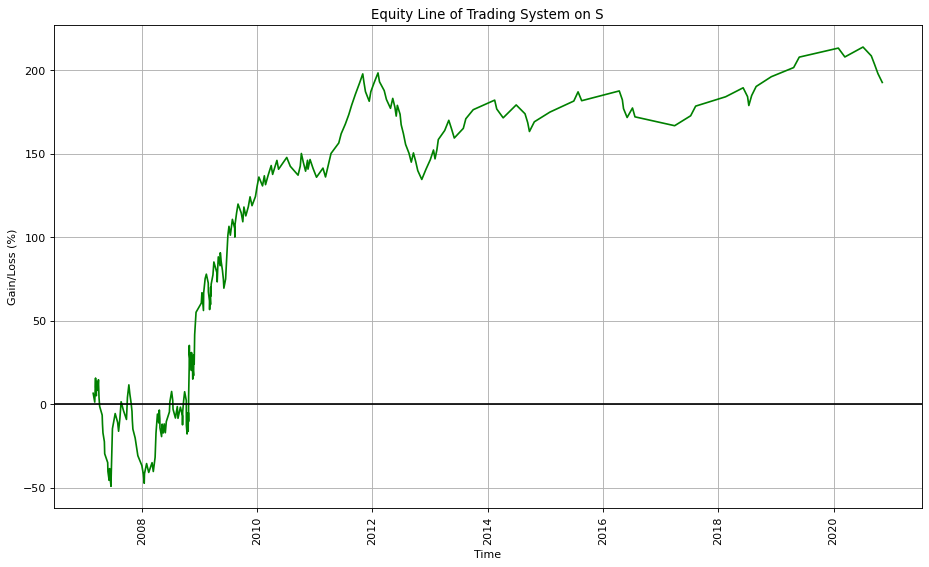

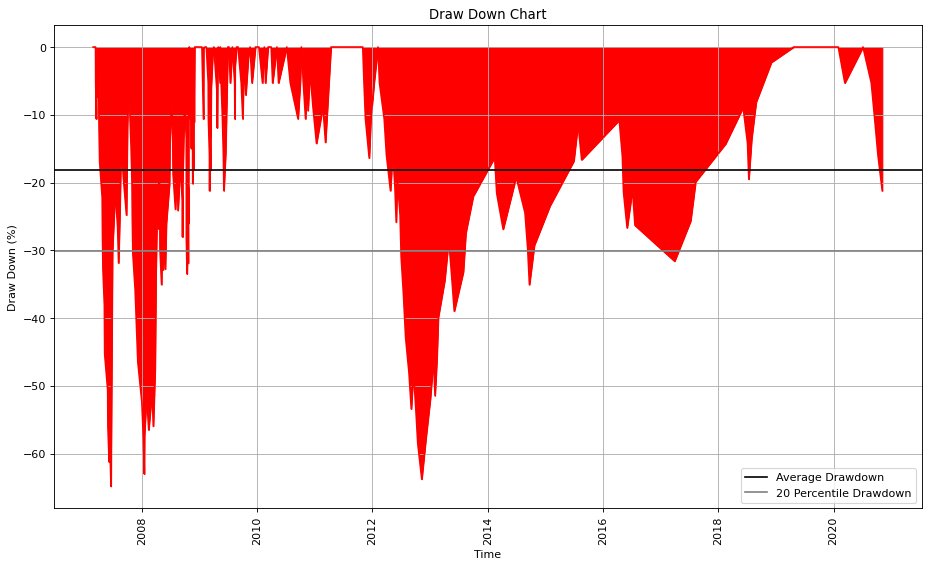

In [8]:
# Performance visualization (new)

perf.plot_charts(profit_loss)